In [21]:
import sys
sys.path.insert(0, '../src')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data, get_last_publish_date

In [22]:
# RBA monthly home lending rates from 1959
# https://www.rba.gov.au/statistics/tables/frequency-statistical-releases.html
# Rates are published 5 business days after the end of the month
publish_date = pd.Timestamp.now() + pd.offsets.MonthBegin(-1) + pd.offsets.BDay(5)
publish_date_days_ago = (pd.Timestamp.now() - publish_date).days
print("publish_date: " + str(publish_date) + " was " + str(publish_date_days_ago) + " days ago.")

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/f5-data.csv'
local_file = '../data/f5-data.csv'
max_age_days = publish_date_days_ago

# First 10 rows are descriptive header rows
skip_rows = 10

df_interest = load_data(csv_url, local_file, max_age_days, skip_rows)

publish_date: 2024-01-08 08:18:58.701469 was 10 days ago.
Using local file


In [23]:
# Data Transformation
df_interest.dropna(subset=['Series ID'], inplace=True)

# Series ID dates are in the format 'Jan-1959' %b-%Y
df_interest['Date'] = df_interest['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df_interest.set_index('Date', inplace=True)

df_interest.tail(6)

,Series ID,FILRSBVRT,FILRSBVOO,FILRHLBVS,FILRHLBVD,FILRHLBVO,FILRHL3YF,FILRHLBVSI,FILRHLBVDI,FILRHLBVDO,...,FILRSAVIIO,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-31,Jul-2023,8.75,10.51,8.52,7.06,9.04,6.65,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,Aug-2023,8.75,10.51,8.52,7.06,9.04,6.58,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-30,Sep-2023,8.75,10.51,8.52,7.06,9.04,6.56,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,Oct-2023,8.75,10.51,8.52,7.06,9.04,6.56,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,Nov-2023,9.00,10.69,8.77,7.31,9.29,6.80,9.35,7.75,9.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,Dec-2023,9.00,10.69,8.77,7.31,9.29,6.80,9.35,7.75,9.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Chart variables
# FILRHLBVS = Financial Interest; Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier
chart_column = 'FILRHLBVS'

start_year = 1960

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df_interest[chart_column].last_valid_index()

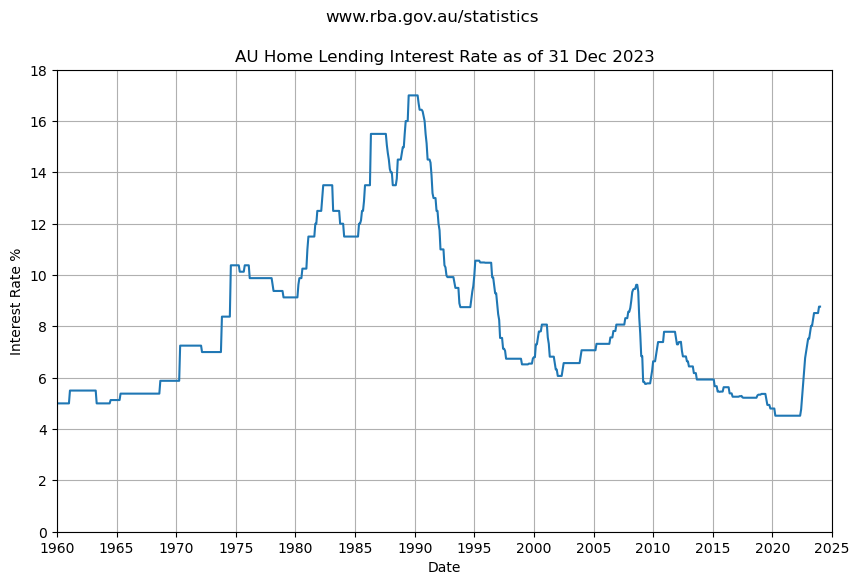

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df_interest.index, df_interest[chart_column])
plt.xlabel('Date')
plt.ylabel('Interest Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Home Lending Interest Rate as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    top_limit = 18
    bottom_limit = 0
    tick_years = 1
else:
    top_limit = 18
    bottom_limit = 0
    tick_years = 5
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)
plt.show()

In [26]:
# 4 quarters per year * 3 years = 12 quarters
df_interest['3_yr_rolling'] = df_interest[chart_column].rolling(window=36, min_periods=12).mean()
df_interest.tail()

,Series ID,FILRSBVRT,FILRSBVOO,FILRHLBVS,FILRHLBVD,FILRHLBVO,FILRHL3YF,FILRHLBVSI,FILRHLBVDI,FILRHLBVDO,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,3_yr_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-31,Aug-2023,8.75,10.51,8.52,7.06,9.04,6.58,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.728333
2023-09-30,Sep-2023,8.75,10.51,8.52,7.06,9.04,6.56,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.839444
2023-10-31,Oct-2023,8.75,10.51,8.52,7.06,9.04,6.56,9.10,7.50,9.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.950556
2023-11-30,Nov-2023,9.00,10.69,8.77,7.31,9.29,6.80,9.35,7.75,9.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.068611
2023-12-31,Dec-2023,9.00,10.69,8.77,7.31,9.29,6.80,9.35,7.75,9.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.186667


In [27]:
# Magic store dataframe to share with combo notebook
%store df_interest

Stored 'df_interest' (DataFrame)
